# Customer Churn Prediction: Data Preprocessing and Feature Engineering

In [2]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Set plot style
plt.style.use('ggplot')
sns.set_style('whitegrid')

In [3]:
# Load the dataset
data_path = "../data/raw/Telco-Customer-Churn.csv"
df = pd.read_csv(data_path)
print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns")

Dataset loaded with 7043 rows and 21 columns


## 1. Data Cleaning

In [4]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

if 'TotalCharges' in df.columns:
    # First check if it's a numeric column
    if df['TotalCharges'].dtype == 'object':
        print("\nConverting TotalCharges to numeric...")
        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

    # Now handle any missing values
    missing_total = df['TotalCharges'].isnull().sum()
    if missing_total > 0:
        print(f"Found {missing_total} missing values in TotalCharges")
        
        # For customers with 0 tenure, TotalCharges should be 0
        if 'tenure' in df.columns:
            df.loc[(df['TotalCharges'].isnull()) & (df['tenure'] == 0), 'TotalCharges'] = 0
            
        # For remaining missing values, use median
        still_missing = df['TotalCharges'].isnull().sum()
        if still_missing > 0:
            median_total = df['TotalCharges'].median()
            df['TotalCharges'].fillna(median_total, inplace=True)
            print(f"Filled {still_missing} missing values with median: {median_total:.2f}")




Missing values per column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Converting TotalCharges to numeric...
Found 11 missing values in TotalCharges


In [5]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
if duplicates > 0:
    print(f"\nFound {duplicates} duplicate rows")
    df.drop_duplicates(inplace=True)
    print("Removed duplicates")
else:
    print("\nNo duplicate rows found")


No duplicate rows found


## 2. Feature Engineering

In [6]:
# Convert binary categorical variables to numeric
binary_variables = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for var in binary_variables:
    if var in df.columns:
        df[var] = df[var].map({'Yes': 1, 'No': 0})


Creating tenure groups...


/var/folders/q6/w07kwt4d0451cwncrd_g_vcr0000gn/T/ipykernel_25026/2551267026.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_churn = df.groupby('TenureGroup')['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)


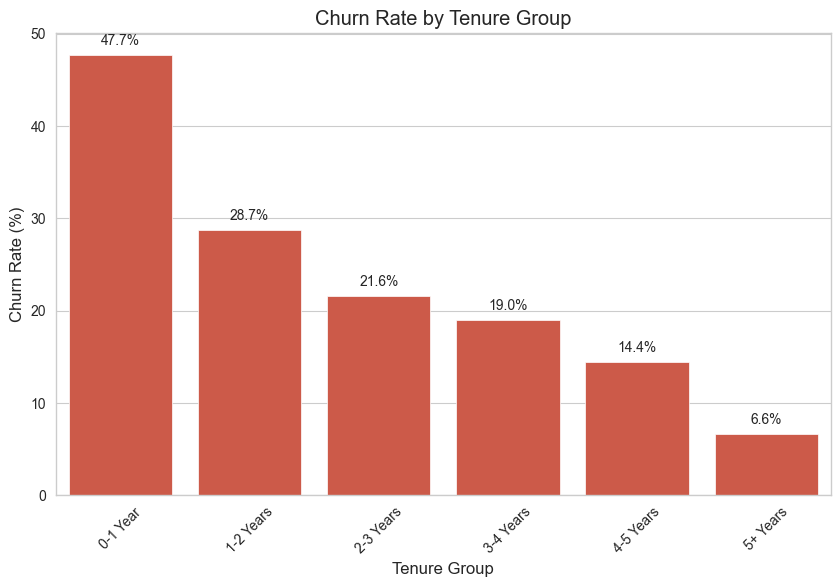

In [8]:
# Create tenure groups
if 'tenure' in df.columns:
    print("\nCreating tenure groups...")
    tenure_bins = [0, 12, 24, 36, 48, 60, np.inf]
    tenure_labels = ['0-1 Year', '1-2 Years', '2-3 Years', '3-4 Years', '4-5 Years', '5+ Years']
    df['TenureGroup'] = pd.cut(df['tenure'], bins=tenure_bins, labels=tenure_labels)
    
    # Visualize churn by tenure group
    plt.figure(figsize=(10, 6))
    tenure_churn = df.groupby('TenureGroup')['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
    ax = sns.barplot(x=tenure_churn.index, y=tenure_churn.values)
    plt.title('Churn Rate by Tenure Group')
    plt.xlabel('Tenure Group')
    plt.ylabel('Churn Rate (%)')
    plt.xticks(rotation=45)

    # Annotate values on the bar plot
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
    plt.show()

As expected, churn is significantly higher for customers with lower tenure. Nearly half of them churn

In [9]:
# Now we will create a column to count all services each customer has
services = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

df['TotalServices'] = df[services].apply(lambda row: sum((row != 'No') & (row != '0') & (row != 0) & (row.notna())), axis=1)



2
9
5.543092432202187


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, '2'),
  Text(1, 0, '3'),
  Text(2, 0, '4'),
  Text(3, 0, '5'),
  Text(4, 0, '6'),
  Text(5, 0, '7'),
  Text(6, 0, '8'),
  Text(7, 0, '9')])

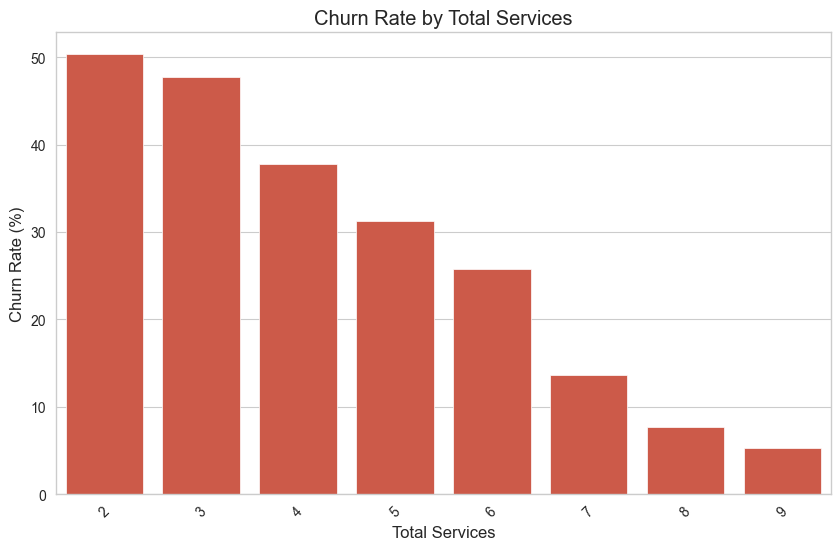

In [11]:
print(df['TotalServices'].min())
print(df['TotalServices'].max())
print(df['TotalServices'].mean())

# Visualize churn by total services
plt.figure(figsize=(10, 6))
services_churn = df.groupby('TotalServices')['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
ax = sns.barplot(x=services_churn.index, y=services_churn.values)
plt.title('Churn Rate by Total Services')
plt.xlabel('Total Services')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=45)

The majority of customers have 2-3 products, however it is clear that the more products you have with the company, the least probable it is for you to churn

In [14]:
# Create monthly billing rate feature
if 'MonthlyCharges' in df.columns and 'TotalCharges' in df.columns and 'tenure' in df.columns:
    # Avoid division by zero for customers with 0 tenure
    df['AvgMonthlyCharges'] = np.where(
        df['tenure'] > 0, 
        df['TotalCharges'] / df['tenure'],
        df['MonthlyCharges']
    )

        
    # Calculate difference between current and average monthly charges
    df['ChargeEvolution'] = df['MonthlyCharges'] - df['AvgMonthlyCharges']

## 3. Categorical Encoding

In [26]:
# Identify categorical columns (excluding target and customer ID)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if 'Churn' in categorical_cols:
    categorical_cols.remove('Churn')
if 'customerID' in categorical_cols:
    categorical_cols.remove('customerID')

print(f"\nCategorical columns to encode: {categorical_cols}")


Categorical columns to encode: ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod', 'TenureGroup']


In [27]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(f"\nDataset after encoding: {df_encoded.shape[0]} rows and {df_encoded.shape[1]} columns")



Dataset after encoding: 7043 rows and 40 columns


## 4. Prepare Target Variable
Here the target variable is already defined, so we will just transform it from (Yes/ No) to 1/0

In [28]:
if 'Churn' in df.columns:
    df_encoded['Churn'] = df_encoded['Churn'].map({'Yes': 1, 'No': 0})

In [30]:
df_encoded = df_encoded.drop(columns=['customerID'])

## 5. Feature Analysis and Selection


Top Correlations with Churn:
Churn                             1.000000
InternetService_Fiber optic       0.308020
PaymentMethod_Electronic check    0.301919
MonthlyCharges                    0.193356
AvgMonthlyCharges                 0.192531
PaperlessBilling                  0.191825
SeniorCitizen                     0.150889
StreamingTV_Yes                   0.063228
StreamingMovies_Yes               0.061382
MultipleLines_Yes                 0.040102
Name: Churn, dtype: float64

Bottom Correlations with Churn:
StreamingMovies_No internet service    -0.227890
StreamingTV_No internet service        -0.227890
TechSupport_No internet service        -0.227890
DeviceProtection_No internet service   -0.227890
OnlineSecurity_No internet service     -0.227890
InternetService_No                     -0.227890
OnlineBackup_No internet service       -0.227890
Contract_Two year                      -0.302253
TotalServices                          -0.323140
tenure                                

<Figure size 1200x1000 with 0 Axes>

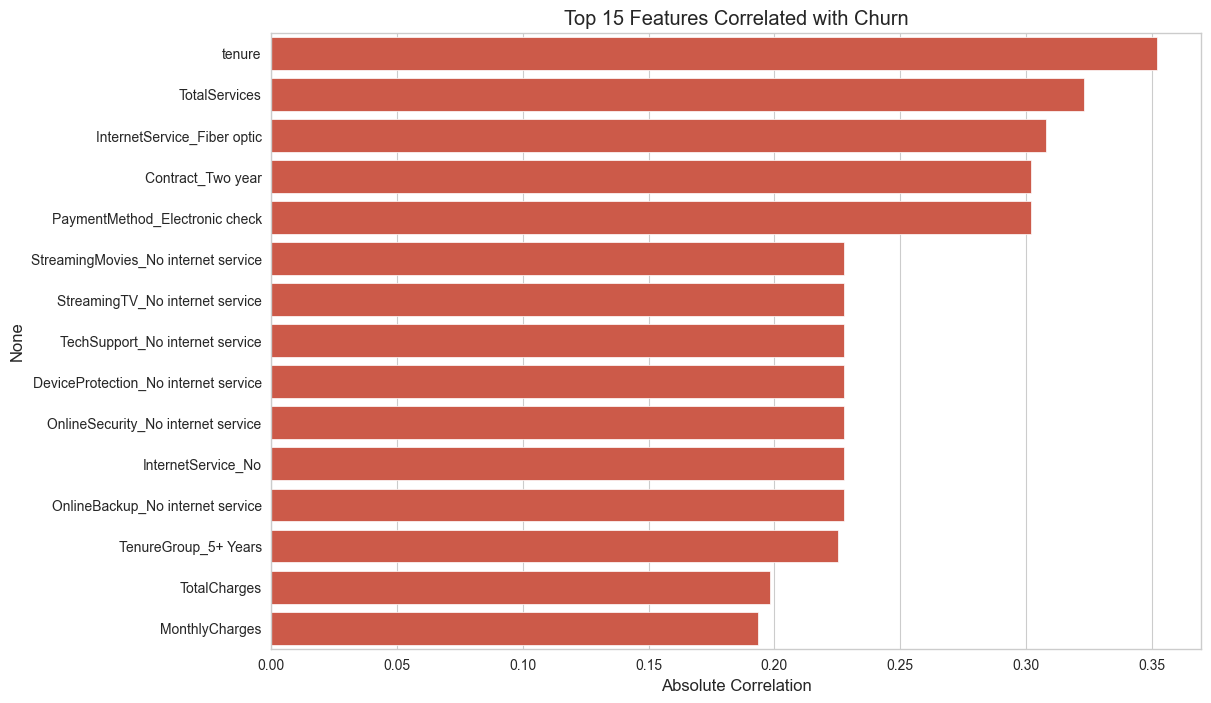

In [32]:
# Correlation with Churn

plt.figure(figsize=(12, 10))
correlation_with_churn = df_encoded.corr()['Churn'].sort_values(ascending=False)
print("\nTop Correlations with Churn:")
print(correlation_with_churn.head(10))
print("\nBottom Correlations with Churn:")
print(correlation_with_churn.tail(10))


# Visualize top 15 correlations
top_correlations = correlation_with_churn[correlation_with_churn.index != 'Churn'].abs().nlargest(15)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_correlations.values, y=top_correlations.index)
plt.title('Top 15 Features Correlated with Churn')
plt.xlabel('Absolute Correlation')
plt.show()

As expected, tenure and number of services seem to be the two mostly correlated features with churn

## 6. Save Processed Dataset

In [33]:
# Save the processed dataset
processed_path = "../data/processed/telco_churn_processed.csv"
df_encoded.to_csv(processed_path, index=False)
print(f"\nProcessed dataset saved to: {processed_path}")



Processed dataset saved to: ../data/processed/telco_churn_processed.csv
